In [0]:
!mkdir results

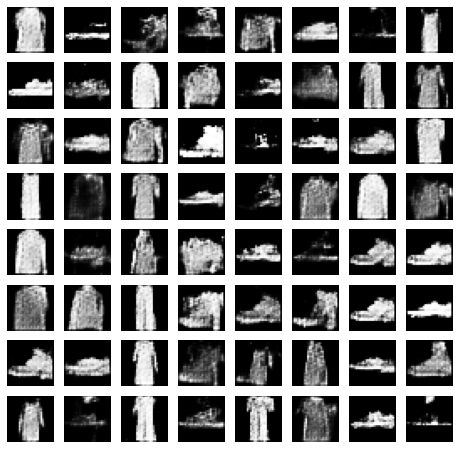

Time for epoch 52 is 12.323271989822388 sec


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
from IPython import display
from enum import Enum


class Dataset(Enum):
    mnsit = 1
    fashion_mnist = 2


# configuration parameters
epochs = 180
batch_size = 256
output_dir = 'results/'
data_set = Dataset.fashion_mnist


class DCGAN:
    def __init__(self):
        # initalize cross entropy loss
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # define adam optimizer
        self.gen_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.dis_optimizer = tf.keras.optimizers.Adam(1e-4)
        # initialize generator and descriminator model
        self.generator = self.generator_model()
        self.discriminator = self.discriminator_model()

    """
    Generator model contains following layers:
     a) Dense layer with 7 * 7 * 256 hidden components
     b) Normalization layer
     c) Activation function: Leak RELU
     d) Upsampling using convolution
    """

    def generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Reshape((7, 7, 256)))
        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        return model

    """
    Discriminator Model contains following layers:
     a) Convolution layer
     b) LeakyReLU function
     c) Dropout regularization layer : to avoid overfitting
     d) Reduce dimension using Flatten and Dense layer
    """

    def discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        model.add(layers.Flatten())
        model.add(layers.Dense(1))
        return model

    def discriminator_loss(self, true_output, fake_output):
        true_loss = self.cross_entropy(tf.ones_like(true_output), true_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        tot_loss = true_loss + fake_loss
        return tot_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, images, batch_size, noise_dim):
        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_img = self.generator(noise, training=True)

            true_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_img, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(true_output, fake_output)

        grad_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        grad_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_generator, self.generator.trainable_variables))
        self.dis_optimizer.apply_gradients(zip(grad_discriminator, self.discriminator.trainable_variables))


noise_dim = 100
seed = tf.random.normal([64, 100])

# Downloads the Fashion-MNIST dataset from keras-datasets
# reshapes and normalizes the images and shuffles the dataset

if data_set==Dataset.fashion_mnist:
    (imgs, lab), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
else:
    (imgs, lab), (_, _) = tf.keras.datasets.mnist.load_data()

imgs = imgs.reshape(imgs.shape[0], 28, 28, 1).astype('float32')
imgs = (imgs - 127.5) / 127.5
dataset = tf.data.Dataset.from_tensor_slices(imgs).shuffle(60000).batch(256)

dcgan = DCGAN()
# start the training
for epoch in range(epochs):
    start = time.time()
    for img_batch in dataset:
        dcgan.train_step(img_batch, batch_size=batch_size, noise_dim=noise_dim)
    display.clear_output(wait=True)
    # Generate sample image
    pred = dcgan.generator(seed, training=False)
    plt.figure(figsize=(8, 8))
    for i in range(pred.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(pred[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(output_dir + 'dcgan_{:04d}_sample.png'.format(epoch + 1))
    plt.show()
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))